In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import (
    pyplot as plt,
    ticker,
)
from tqdm.notebook import tqdm
import requests
import librosa
import jiwer
import warnings
import whisper.normalizers

text_normalizer = whisper.normalizers.EnglishTextNormalizer()
warnings.filterwarnings(
    action="ignore",
    message="PySoundFile.*",
    category=FutureWarning,
    module=".*",
)
plt.style.use("minimal.mplstyle")

class COLORMAP:
    F1_red = "#E10600"

audio_files_path = Path() / "data" / "radio_messages/"

- ALEALB01_23_20240229_154846 optics > upshift
- LANNOR01_4_20250419_205244 im an f'ing idiot
- MAXVER01_1_20250413_181201 lado > lando
- LANNOR01_4_20240824_122457 landon > lando
- LANNOR01_4_20250906_163307 map > lap
- LANNOR01_4_20241201_113249 can't hear your – strat 10!!!
- MAXVER01_1_20251109_152028 deck > deg(radation)
- ANDANT01_12_20250316_170136 [silence gets transcribed as "thank you"] 
- LIALAW01_30_20250615_151510 peel > PU
- GUAZHO01_24_20240706_113306 upship > upshift
- LANNOR01_4_20240405_034437 landau > Lando
- LANNOR01_4_20240302_153321 lina > Lando

In [ ]:
def get_json(url):
    return requests.get(url).json()

radio_messages = pd.merge(
    left=pd.DataFrame.from_records(get_json("https://api.openf1.org/v1/team_radio")),
    right=pd.DataFrame.from_records(get_json("https://api.openf1.org/v1/sessions"))[[
        "session_key",
        "location",
        "year",
        "session_name",
    ]],
    on="session_key",
    how="left",
).rename(columns=dict(
    date="timestamp",
)).astype(dict(
    timestamp="datetime64[ns, UTC]",
)).sort_values("timestamp")

radio_messages["identifier"] = radio_messages["recording_url"].str.split("/").str[-1]
radio_messages["file_path"] = (audio_files_path / radio_messages["identifier"]).astype(str)

print(f"Found {len(radio_messages)} radio messages")
radio_messages.tail(3)

Found 16420 radio messages


,meeting_key,session_key,driver_number,timestamp,recording_url,location,year,session_name,identifier,file_path
16320,1276,9839,4,2025-12-07 14:25:01.949000+00:00,https://livetiming.formula1.com/static/2025/20...,Yas Island,2025,Race,LANNOR01_4_20251207_182444.mp3,data/radio_messages/LANNOR01_4_20251207_182444...
16321,1276,9839,4,2025-12-07 14:32:13.730000+00:00,https://livetiming.formula1.com/static/2025/20...,Yas Island,2025,Race,LANNOR01_4_20251207_183123.mp3,data/radio_messages/LANNOR01_4_20251207_183123...
16322,1276,9839,1,2025-12-07 14:33:14.515000+00:00,https://livetiming.formula1.com/static/2025/20...,Yas Island,2025,Race,MAXVER01_1_20251207_183223.mp3,data/radio_messages/MAXVER01_1_20251207_183223...


In [ ]:
# def get_clip_duration(file_path):
#     try:
#         return librosa.get_duration(path=file_path)
#     except:
#         return np.nan

# if not "clip_duration" in radio_messages.columns:
#     radio_messages["clip_duration"] = radio_messages["file_path"].apply(get_clip_duration)
#     # radio_messages = radio_messages[radio_messages["clip_duration"] < 30]

# plt.hist(
#     radio_messages["clip_duration"],
#     bins=np.arange(0, 45, 0.5),
#     color=COLORMAP.F1_red,
#     edgecolor="white",
#     linewidth=1,
# )
# plt.axvline(
#     x=radio_messages["clip_duration"].mean(),
#     color="silver",
#     linestyle="dotted",
#     label=f"Mean {radio_messages["clip_duration"].mean():.1f} sec",
# )
# plt.axvline(
#     x=radio_messages["clip_duration"].median(),
#     color="silver",
#     linestyle="dashed",
#     label=f"Median {radio_messages["clip_duration"].median():.1f} sec",
# )
# plt.legend(loc="upper right")
# plt.xlabel("Audio clip duration [sec]")
# plt.ylabel(f"Occurences ({len(radio_messages)} total)")
# plt.show()

In [6]:
def download_audiofiles(file_path_todo_list):
    for _, radio_message in tqdm(list(file_path_todo_list), smoothing=0):
        if not Path(radio_message["file_path"]).exists():
            try:
                with open(radio_message["file_path"], mode="wb") as file:
                    file.write(requests.get(radio_message["recording_url"]).content)
            except:
                print("Failed on", radio_message["file_path"])

download_audiofiles(
    file_path_todo_list=radio_messages[~radio_messages["file_path"].apply(Path).apply(Path.exists)][["recording_url", "file_path"]].iloc[::-1].iterrows(),
)

0it [00:00, ?it/s]

---

In [66]:
human_labeling_export = pd.read_json(sorted(Path("label-studio/export").iterdir())[-1]).rename(columns=dict(
    transcription="human_transcription",
)).drop_duplicates(
    subset="identifier",
    keep="last",
)

with_human_reference = pd.merge(
    left=radio_messages,
    right=human_labeling_export[[
        "identifier",
        "human_transcription",
        "lead_time",
        "updated_at",
    ]].rename(columns=dict(updated_at="human_transcription_timestamp")),
    on="identifier",
    how="right",
)

with_human_reference = with_human_reference[~with_human_reference["human_transcription"].isna()]

with_human_reference[[
    "identifier",
    "file_path",
    "human_transcription",
]].to_json(
    "data/with_human_reference.json", 
    index=False,
    orient="records",
)

print(f"Found {len(with_human_reference.drop_duplicates(subset="identifier"))} machine transcribed radio messages with human reference")
with_human_reference.sample(3)

Found 755 machine transcribed radio messages with human reference


,meeting_key,session_key,driver_number,timestamp,recording_url,location,year,session_name,identifier,file_path,human_transcription,lead_time,human_transcription_timestamp
512,1249,9627,81,2024-11-03 11:20:15.331000+00:00,https://livetiming.formula1.com/static/2024/20...,São Paulo,2024,Qualifying,OSCPIA01_81_20241103_052011.mp3,data/radio_messages/OSCPIA01_81_20241103_05201...,"cars have been told to push the outlap, obviou...",25.019,2025-12-13 15:22:21.037044+00:00
420,1277,9947,81,2025-07-06 14:29:46.595000+00:00,https://livetiming.formula1.com/static/2025/20...,Silverstone,2025,Race,OSCPIA01_81_20250706_152915.mp3,data/radio_messages/OSCPIA01_81_20250706_15291...,,5.825,2025-12-13 08:05:40.921016+00:00
34,1269,9904,14,2025-09-21 10:16:41.698000+00:00,https://livetiming.formula1.com/static/2025/20...,Baku,2025,Race,FERALO01_14_20250921_141637.mp3,data/radio_messages/FERALO01_14_20250921_14163...,****,NaN,2025-12-07 10:31:30.921253+00:00


---

In [ ]:
machine_transcriptions = pd.read_csv("exports/transcriptions.tsv", delimiter="\t").astype(dict(
    transcription_timestamp="datetime64[ns, UTC]",
))

machine_vs_human_transcriptions = pd.merge(
    left=with_human_reference.drop(columns=[
        "meeting_key",
        "session_key",
    ]),
    right=machine_transcriptions,
    on="identifier",
    how="left",
).sort_values("transcription_timestamp").drop_duplicates(
    subset=("identifier", "modelidentifier"),
    keep="first",
)
# machine_vs_human_transcriptions = machine_vs_human_transcriptions[~machine_vs_human_transcriptions["transcription"].isna()]
# machine_vs_human_transcriptions = machine_vs_human_transcriptions[~(machine_vs_human_transcriptions["human_transcription"].str.strip() == "")]

print(f"Found {len(machine_vs_human_transcriptions.drop_duplicates(subset="identifier"))} machine transcribed radio messages")
machine_vs_human_transcriptions.tail(3)

Found 755 machine transcribed radio messages


,driver_number,timestamp,recording_url,location,year,session_name,identifier,file_path,human_transcription,lead_time,...,transcription_timestamp,modelidentifier,transcription,avg_logprob,text_nbest,no_speech_prob,temperature,compression_ratio,sum_logprob_nbest,token_nbest
1335,81,2025-11-28 14:00:57.564000+00:00,https://livetiming.formula1.com/static/2025/20...,Lusail,2025,Practice 1,OSCPIA01_81_20251128_170037.mp3,data/radio_messages/OSCPIA01_81_20251128_17003...,Toggle recharge.,7.474,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1336,22,2025-12-06 11:24:36.049000+00:00,https://livetiming.formula1.com/static/2025/20...,Yas Island,2025,Practice 3,YUKTSU01_22_20251206_152408.mp3,data/radio_messages/YUKTSU01_22_20251206_15240...,I had a massive crash. Have you got damage? I...,21.963,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1337,81,2025-11-29 19:08:13.730000+00:00,https://livetiming.formula1.com/static/2025/20...,Lusail,2025,Qualifying,OSCPIA01_81_20251129_220728.mp3,data/radio_messages/OSCPIA01_81_20251129_22072...,"So did we get it? Yep, you got it. Just becau...",22.148,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for metric, estimator in [
    ("wer", jiwer.wer),
    ("wip", jiwer.wip),
]:
    with_human_reference[metric] = with_human_reference.apply(lambda radio_message: estimator(
        text_normalizer(radio_message["transcription"]),
        text_normalizer(radio_message["human_transcription"]),
    ), axis=1)
    plt.hist(
        with_human_reference[metric],
        bins=dict(
            wer=200,
            wip=np.linspace(0, 1, 100),
        )[metric],
        density=True,
        color=COLORMAP.F1_red,
        edgecolor="white",
        linewidth=1,
    )
    plt.axvline(
        color="silver",
        linestyle="dashed",
    )
    plt.axvline(
        x=with_human_reference[metric].mean(),
        color="silver",
        linestyle="dotted",
        label=f"Mean {with_human_reference[metric].mean():.1%}",
    )
    plt.axvline(
        x=with_human_reference[metric].median(),
        color="silver",
        linestyle="dashed",
        label=f"Median {with_human_reference[metric].median():.1%}",
    )
    plt.legend(loc="upper right")
    plt.xlabel(metric.upper())
    plt.ylabel("PDF")
    if metric == "wip":
        plt.xlim(0, 1)
    elif metric == "wer":
        plt.xlim(0, 3)
    plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1))
    plt.show()

KeyError: 'transcription'

In [15]:
# fig, ax = plt.subplots(figsize=(4.5, 5))

# for row_idx, (driver_number, driver_data) in enumerate(with_reference.groupby("driver_number")):
#     hist, bin_edges = np.histogram(
#         driver_data["wip"],
#         bins=np.linspace(0, 1, 50),
#     )
#     plt.bar(
#         x=bin_edges[:-1],
#         height=np.array(hist) / max(hist) / 1.2,
#         bottom=row_idx,
#         width=0.018,
#         color=COLORMAP.F1_red,
#         align="edge",
#     )
#     plt.vlines(
#         x=driver_data["wip"].median(),
#         ymin=row_idx,
#         ymax=row_idx + 1,
#         color="silver",
#         linestyle="dashed",
#     )

# plt.yticks(range(with_reference["driver_number"].nunique()), with_reference["driver_number"].sort_values(ascending=False).unique())
# plt.ylabel("Driver number", y=1.02, rotation=0, ha="left")
# plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1))
# plt.xlim(0, 1)
# plt.xlabel("Clip duration [sec]")
# plt.xlabel("WIP")
# plt.show()

In [ ]:
# plt.scatter(
#     with_reference["clip_duration"],
#     with_reference["wip"],
#     color=COLORMAP.F1_red,
#     edgecolor="white",
#     alpha=0.5,
#     clip_on=False,
#     zorder=5,
# )
# plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
# plt.xscale("log", base=10)
# plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
# plt.ylim(0, 1)
# plt.xlabel("Clip duration [sec]")
# plt.ylabel("WIP")
# plt.show()

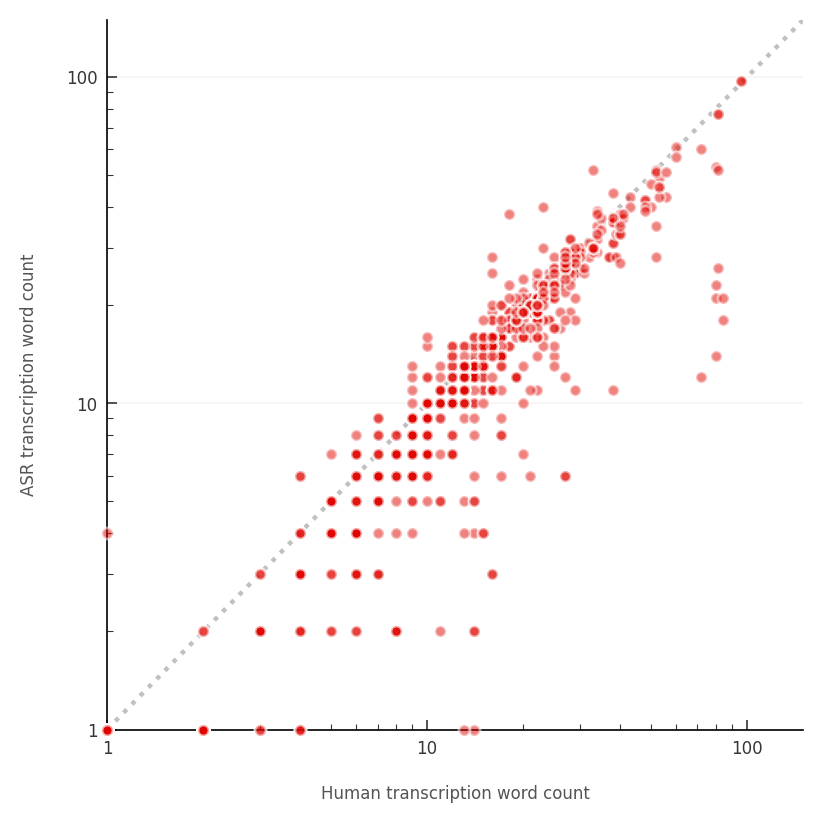

In [ ]:
plt.figure(figsize=(4, 4))
plt.scatter(
    with_human_reference["human_transcription"].str.split(" ").str.len(),
    with_human_reference["transcription"].str.split(" ").str.len(),
    color=COLORMAP.F1_red,
    edgecolor="white",
    alpha=0.5,
    clip_on=False,
    zorder=5,
)
plt.plot(
    [0, 1],
    [0, 1],
    transform=plt.gca().transAxes,
    color="silver",
    linestyle="dotted",
    zorder=-1,
)
plt.xscale("log", base=10)
plt.yscale("log", base=10)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.xlim(1, 150)
plt.ylim(1, 150)
plt.xlabel("Human transcription word count")
plt.ylabel("ASR transcription word count")
plt.show()

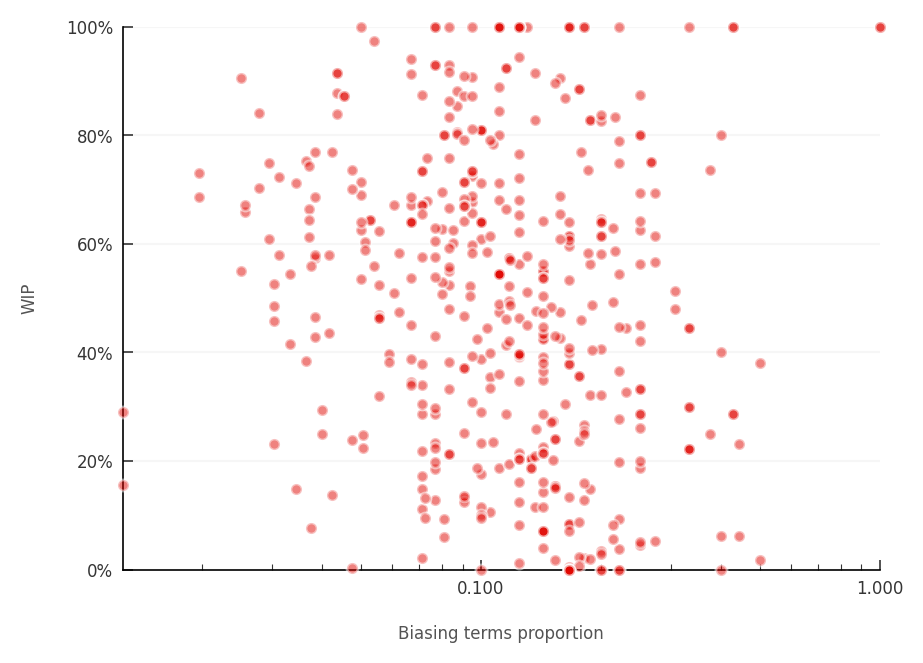

In [ ]:
with open("data/biasing_list.txt") as file:
    biasing_terms = [word.strip() for word in file]

def biasing_terms_in_utterance(utterance):
    words = [word.strip(r"\"!#$%&'()*+,./:;<=>?@[\]^_`{|}~") for word in utterance.upper().split()]
    return list(set([word for word in words if word in biasing_terms]))
    
with_human_reference["biasing_terms"] = with_human_reference["human_transcription"].apply(biasing_terms_in_utterance)

plt.scatter(
    with_human_reference["biasing_terms"].apply(len) / with_human_reference["human_transcription"].str.split().str.len(),
    with_human_reference["wip"],
    color=COLORMAP.F1_red,
    edgecolor="white",
    alpha=0.5,
    clip_on=False,
    zorder=5,
)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.xscale("log", base=10)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
# plt.xlim(right=1)
plt.ylim(0, 1)
plt.xlabel("Biasing terms proportion")
plt.ylabel("WIP")
plt.show()

<!-- ln -s radio_messages/ /home/ucloud/.local/share/label-studio/radio_messages -->

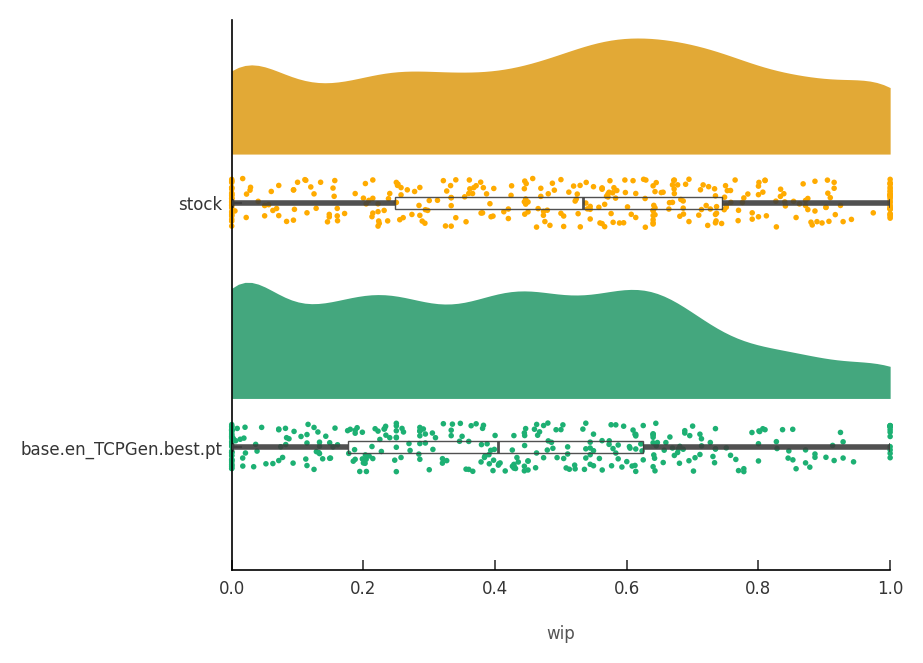

In [ ]:
import ptitprince as pt
fig, ax = plt.subplots()
ax = pt.RainCloud(
    data=with_human_reference,
    x="modelidentifier",
    y="wip",
    hue="modelidentifier",
    bw=0.2, 
    palette=[f"C{i + 1}" for i in range(with_human_reference["modelidentifier"].nunique())],
    width_viol=0.95, 
    width_box=0.05, 
    linewidth=0,
    alpha=0.9,
    cut=0,
    point_size=2,
    orient="h",
    rain_clip_on=False,
    ax=ax, 
)
plt.ylabel("")
# plt.margins(x=0.1)
# plt.xlim(0, 1)
plt.show()

In [ ]:
with_human_reference.groupby("modelidentifier")["wip"].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
modelidentifier,,,,,,,,
base.en_TCPGen.best.pt,345.0,0.46,0.30,0.0,0.22,0.47,0.69,1.0
stock,344.0,0.50,0.31,0.0,0.24,0.54,0.74,1.0


In [ ]:
with_human_reference[with_human_reference["biasing_terms"].apply(len) > 0].groupby("modelidentifier")["wip"].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
modelidentifier,,,,,,,,
base.en_TCPGen.best.pt,229.0,0.49,0.28,0.0,0.26,0.50,0.69,1.0
stock,229.0,0.54,0.28,0.0,0.32,0.57,0.75,1.0
